# Optimizing hyperparameters

In [1]:
import os
os.chdir('../../../')

The model we have just trained works OK, but there are several choices we can make (beyond simply using the default parameters) about how the model should go about training. These choices, or **hyperparameters** will affect the performance of our model, in ways that we cannot always predict *a priori*. It is however likely that the default parameters are not the best ones.

## Choosing parameters with huggingface

We can set the parameters with a [TrainingArguments](https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/trainer#transformers.TrainingArguments) object, which we then pass to our Trainer.

The orignal BERT paper recommends we explore the following hyperparameter space

In [2]:
params = {
  "per_device_train_batch_size": [16, 32],
  "learning_rate": [5e-5, 3e-5, 2e-5],
  "num_train_epochs": [2,3,4]
}

We can turn this into a list of unique combinations using itertools

In [3]:
import itertools
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))
param_list = list(product_dict(**params))
print(len(param_list))

18


In [4]:
from myst_nb import glue
glue('n_params', len(param_list))

18

There are {glue:}`n_params` unique combinations of parameters in there. We'll first explore how we can test out one set.

One thing we'll need to do is to separate a test set of documents from our training set. Our training procedure will not see these documents, and we'll see how well our model does at predicting the right values for documents it has not seen before.

In [5]:
from datasets import Dataset
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from mlmap import hf_tokenize_data, CustomTrainer
df = pd.read_feather('data/labels.feather').sample(128, random_state=2023).reset_index(drop=True)
df['text'] = df['title'] + ' ' + df['abstract']
y_prefix = 'INCLUDE'
targets = [x for x in df.columns if re.match(f'^{y_prefix}',x)]
if len(targets)==1:
    df['labels'] = df[targets[0]]
    binary=True
else:
    df['labels'] = df[targets]
    binary=False

model_name = 'distilroberta-base'
dataset = hf_tokenize_data(df, model_name)
train_idx, test_idx = train_test_split(df.index)
train_data = dataset.select(train_idx)
test_data = dataset.select(test_idx)

/home/galm/Documents/ml-map/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Map:   0%|                                                                                  | 0/128 [00:00<?, ? examples/s]

Map: 100%|██████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 6604.39 examples/s]

Now we have split our data up, we want to train a model with a given set of parameters on our training data, and test it on our testing data

In [6]:
from transformers import Trainer, AutoModelForSequenceClassification, TrainingArguments
p = param_list[0]
training_args = TrainingArguments(
    output_dir='./results',
    save_steps=1e9,
    optim='adamw_torch'
)
for k, v in p.items():
    setattr(training_args,k,v)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
trainer = CustomTrainer(model, train_dataset=train_data, args=training_args)
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=12, training_loss=0.6416730880737305, metrics={'train_runtime': 5.874, 'train_samples_per_second': 32.686, 'train_steps_per_second': 2.043, 'total_flos': 25433740541952.0, 'train_loss': 0.6416730880737305, 'epoch': 2.0})

Now we can see how well this work on our test dataset

0.0

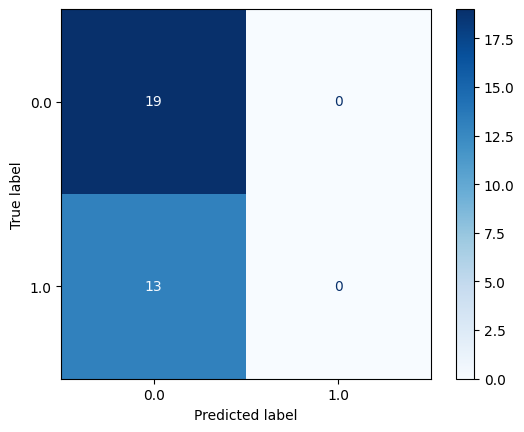

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
pred = trainer.predict_proba(test_data, binary=binary)

y_true = df.loc[test_idx,'labels']
glue('f1_p0', f1_score(y_true, pred.round()))

ConfusionMatrixDisplay.from_predictions(
    y_true,
    pred.round(),
    cmap='Blues'
)


This model achieved and f1 score of {glue:}`f1_p0`.

## Class weighting

The optimization procedure of our model penalizes mistaken classifications for all classes equally. Where we have unbalanced classes, this might mean our model gets good at predicting one common class at the expense of another less common class. This would not be ideal behaviour.

We can penalize infrequent classes more heavily by calculating weights as follows

In [8]:
from torch import tensor, cuda, device
device = "cuda:0" if cuda.is_available() else "cpu"
weights = tensor(df.shape[0] / df[targets].sum(axis=0))
weights = weights.to(device)
weights

/tmp/ipykernel_4017822/1975293931.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = tensor(df.shape[0] / df[targets].sum(axis=0))


tensor([2.9091], device='cuda:0', dtype=torch.float64)

We can subclass TrainingArguments

In [9]:
from mlmap import CustomTrainingArguments

training_args = CustomTrainingArguments(
    output_dir='./results',
    save_steps=1e9,
    optim='adamw_torch'
)
training_args.class_weights = weights
training_args.use_class_weights = True
for k, v in p.items():
    setattr(training_args,k,v)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
trainer = CustomTrainer(model, train_dataset=train_data, args=training_args)
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=12, training_loss=1.0991787910461426, metrics={'train_runtime': 5.2644, 'train_samples_per_second': 36.472, 'train_steps_per_second': 2.279, 'total_flos': 25433740541952.0, 'train_loss': 1.0991787910461426, 'epoch': 2.0})

0.6842105263157895

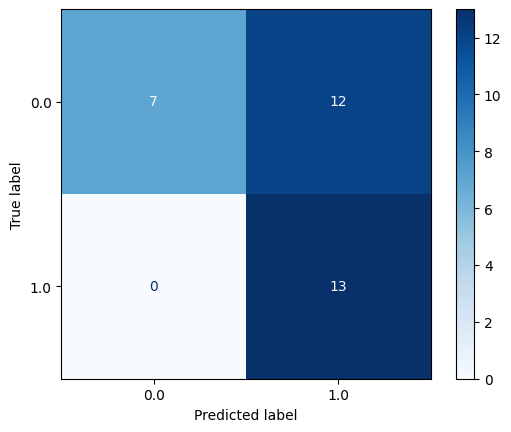

In [10]:
pred = trainer.predict_proba(test_data, binary=binary)

y_true = df.loc[test_idx,'labels']
glue('f1_p0c', f1_score(y_true, pred.round()))

ConfusionMatrixDisplay.from_predictions(
    y_true,
    pred.round(),
    cmap='Blues'
)


This model achieved and f1 score of {glue:}`f1_p0c`.